# **Prediction of Covid-19 Deaths and Cases by Method of Regression Modeling**

## Data 100. Spring 2020 Final Project
### Names: Emmy Yu, Ruqian Wang, Shaye Hong



In [0]:
#Important Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
import random 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import folium
import folium.plugins # The Folium Javascript Map Library
from folium.plugins import HeatMap
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV

import warnings
warnings.filterwarnings("ignore")

## **About the Datasets: Covid-19**

- **Confirmed Cases:**
([time_series_covid19_confirmed_US.csv ](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv))


- **Confirmed Deaths:**
([time_series_covid19_deaths_US.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv))


- **Counties Statistics:** ([abridged_couties.csv](https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/county_data_abridged.csv), 
[Column Descriptions](https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md))


- **States Statistics:** ([4.18states.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-18-2020.csv))



In [61]:
#mounting Google Drive with Covid19 dataset 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
path1 = "/content/drive/My Drive/covid19/time_series_covid19_confirmed_US.csv"
cases = pd.read_csv(path1)
cases.head()

UID iso2 iso3  code3  FIPS  ... 4/14/20 4/15/20 4/16/20  4/17/20  4/18/20
0   16   AS  ASM     16  60.0  ...       0       0       0        0        0
1  316   GU  GUM    316  66.0  ...     133     135     135      136      136
2  580   MP  MNP    580  69.0  ...      11      13      13       13       14
3  630   PR  PRI    630  72.0  ...     923     974    1043     1068     1118
4  850   VI  VIR    850  78.0  ...      51      51      51       51       53

[5 rows x 99 columns]

In [63]:
path2 = "/content/drive/My Drive/covid19/time_series_covid19_deaths_US.csv"
deaths = pd.read_csv(path2)
deaths.head()

UID iso2 iso3  code3  FIPS  ... 4/14/20 4/15/20 4/16/20  4/17/20  4/18/20
0   16   AS  ASM     16  60.0  ...       0       0       0        0        0
1  316   GU  GUM    316  66.0  ...       5       5       5        5        5
2  580   MP  MNP    580  69.0  ...       2       2       2        2        2
3  630   PR  PRI    630  72.0  ...      45      51      56       58       60
4  850   VI  VIR    850  78.0  ...       1       1       1        2        3

[5 rows x 100 columns]

In [64]:
path3 = "/content/drive/My Drive/covid19/abridged_couties.csv"
counties = pd.read_csv(path3)
counties.head()

countyFIPS  STATEFP  ...  HPSAServedPop HPSAUnderservedPop
0      01001      1.0  ...            NaN                NaN
1      01003      1.0  ...            NaN                NaN
2      01005      1.0  ...         5400.0            18241.0
3      01007      1.0  ...        14980.0             6120.0
4      01009      1.0  ...        31850.0            25233.0

[5 rows x 87 columns]

In [65]:
path4 = "/content/drive/My Drive/covid19/4.18states.csv"
states = pd.read_csv(path4)
states.head()

Province_State Country_Region  ... Testing_Rate  Hospitalization_Rate
0         Alabama             US  ...   907.206961             13.157895
1          Alaska             US  ...  1615.226458             12.420382
2  American Samoa             US  ...     5.391708                   NaN
3         Arizona             US  ...   701.291175             11.981372
4        Arkansas             US  ...   932.435235             16.685780

[5 rows x 18 columns]

# **Exploratory Data Analysis** 

The following plot shows the geographical location of each of the counties given in the dataset of confirmed deaths. Note the geographical density of the counties. In the next few maps, the number of confirmed deaths and cases due to Covid-19 will displayed. 

In [66]:
usa = folium.Map([37.0902, -95.7129], zoom_start=4.5)

lat = np.array(deaths['Lat'])
lon = np.array(deaths['Long_'])
coordinates = np.vstack((lat, lon)).T

for coord in coordinates:
    usa.add_child(folium.CircleMarker(coord, fill_opacity=.5, color='darkslateblue', radius=1))
usa

In [67]:
deaths_only = deaths[deaths['4/18/20'] !=0]
deaths_only.shape

(1217, 100)

**Mapping confirmed deaths in the U.S. as of 4/18/20.**

The size of each of the markers corresponds to the number of confirmed deaths due to Covid-19. As an interactive feature, clicking on each marker will display the location name and the actual number of deaths in the county as of 4/18/20. Note that the counties with 0 confirmed deaths are left out of the map. Non-contiguous U.S. states and territories are left out of the initial zoomed frame. 

In [68]:
usa = folium.Map([37.0902, -95.7129], zoom_start=5)

for index, row in deaths_only.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "{}; {}"
    popup_text = popup_text.format(row['Combined_Key'], row['4/18/20'])
    folium.CircleMarker(location=(row["Lat"],
                                  row["Long_"]),
                        radius= row['4/18/20']/10,
                        popup=popup_text,
                        color="cadetblue",
                        fill=False).add_to(usa)
usa

In [69]:
cases_only = cases[cases['4/18/20'] !=0]
cases_only.shape

(2738, 99)

**Mapping confirmed cases in the U.S. as of 4/18/20.**

The size of each of the markers corresponds to the number of confirmed caes due to Covid-19. As an interactive feature, clicking on each marker will display the location name and the actual number of cases in the county as of 4/18/20. Note that the counties with 0 confirmed cases are left out of the map. For the ease of visualization, the scale of the marker sizes has increased (10 times) from the map of confirmed deaths (there are much more confirmed cases than deaths). 

In [70]:
usa = folium.Map([37.0902, -95.7129], zoom_start=5)

for index, row in cases_only.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "{}; {}"
    popup_text = popup_text.format(row['Combined_Key'], row['4/18/20'])
    folium.CircleMarker(location=(row["Lat"],
                                  row["Long_"]),
                        radius= row['4/18/20']/100,
                        popup=popup_text,
                        color="sienna",
                        fill=False).add_to(usa)
usa

By looking at the marker sizes in the graphs above, it is obvious that the greatest number of confirmed cases come from New York. After sorting the cumulative cases counts, the top 4 counties with the highest confirmed cases  and the top 2 counties with the highest deaths come from New York. The actual values on 4/18/20 are displayed below alongside their respective population size. Unassigned data values will be dropped in in the data cleaning portion of this notebook. 

In [71]:
cases_copy = cases.copy()
cases_copy['Population'] = deaths['Population']
cases_copy.sort_values(by='4/18/20', ascending=False)[['Admin2', 'Province_State', '4/18/20', 'Population']].head()

Admin2 Province_State  4/18/20  Population
1863     New York       New York   135572     5803210
1862       Nassau       New York    29180     1356924
1884      Suffolk       New York    26143     1476601
1892  Westchester       New York    23179      967506
615          Cook       Illinois    20395     5150233

In [72]:
deaths.sort_values(by='4/18/20', ascending=False)[['Admin2', 'Province_State', '4/18/20', 'Population']].head()

Admin2 Province_State  4/18/20  Population
1863    New York       New York    13202     5803210
1862      Nassau       New York     1109     1356924
1317       Wayne       Michigan     1070     1749343
3233  Unassigned       New York     1059           0
615         Cook       Illinois      860     5150233

To help determine which features and geographic locations might be important for understanding the spread of COVID-19, we examined the number of deaths and infections over time for the areas with the highest and lowest infection rates. 

In [73]:
us_states = states.loc[states['Country_Region']=='US'].drop(columns = ['Country_Region'])

highest_deaths = us_states.sort_values('Deaths', ascending = False)['Province_State'].iloc[0:3].tolist()
lowest_deaths = us_states.loc[us_states['Deaths'] != 0].sort_values('Deaths', ascending = True)['Province_State'].iloc[0:3].tolist()

highest_cases = us_states.sort_values('Confirmed', ascending = False)['Province_State'].iloc[0:3].tolist()
lowest_cases = us_states.loc[us_states['Deaths'] != 0].sort_values('Confirmed', ascending = True)['Province_State'].iloc[0:3].tolist()

print(f'Highest number of deaths found in: {highest_deaths}')
print(f'Lowest number of deaths found in: {lowest_deaths}')
print(f'Highest number of cases found in: {highest_cases}')
print(f'Lowest number of cases found in: {lowest_cases}')

Highest number of deaths found in: ['New York', 'New Jersey', 'Michigan']
Lowest number of deaths found in: ['Wyoming', 'Northern Mariana Islands', 'Virgin Islands']
Highest number of cases found in: ['New York', 'New Jersey', 'Massachusetts']
Lowest number of cases found in: ['Northern Mariana Islands', 'Virgin Islands', 'Guam']


In [0]:
state_deaths = deaths.groupby('Province_State').apply(sum).drop(columns = ['Country_Region','Province_State','UID','iso2','iso3','code3','FIPS','Admin2','Lat','Long_','Combined_Key','Population'])
hd_data = state_deaths.loc[highest_deaths,:].swapaxes('index','columns')
ld_data = state_deaths.loc[lowest_deaths,:].swapaxes('index','columns')

state_cases = cases.groupby('Province_State').apply(sum).drop(columns = ['Country_Region','Province_State','UID','iso2','iso3','code3','FIPS','Admin2','Lat','Long_','Combined_Key'])
hc_data = state_cases.loc[highest_cases,:].swapaxes('index','columns')
lc_data = state_cases.loc[lowest_cases,:].swapaxes('index','columns')

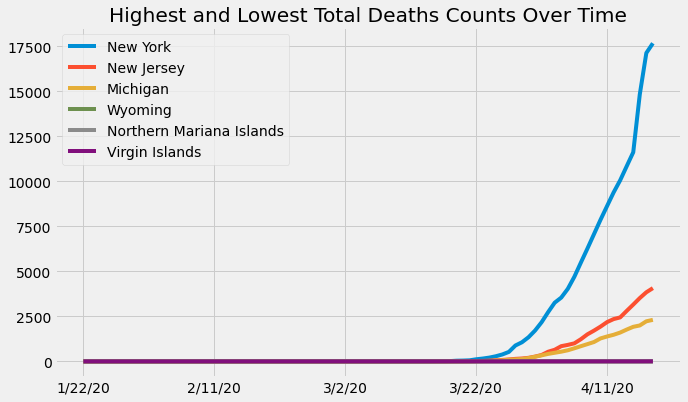

In [75]:
plt.subplots(1,1, figsize=(10,6))
hd_data.iloc[:,0].plot(use_index = True, label = hd_data.columns[0])
hd_data.iloc[:,1].plot(use_index = True, label = hd_data.columns[1])
hd_data.iloc[:,2].plot(use_index = True, label = hd_data.columns[2])

ld_data.iloc[:,0].plot(use_index = True, label = ld_data.columns[0])
ld_data.iloc[:,1].plot(use_index = True, label = ld_data.columns[1])
ld_data.iloc[:,2].plot(use_index = True, label = ld_data.columns[2])

plt.title('Highest and Lowest Total Deaths Counts Over Time')
plt.legend()
plt.show()

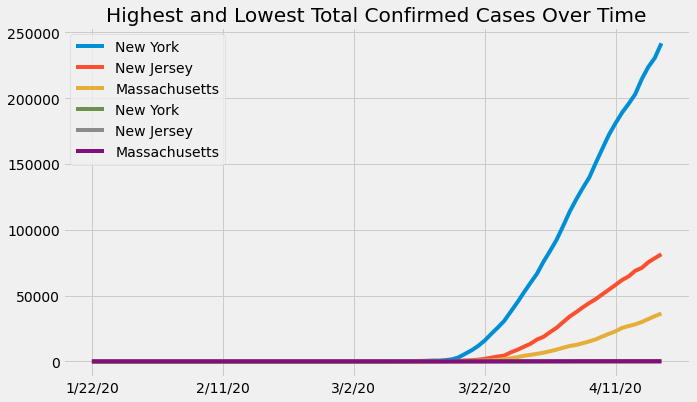

In [76]:
plt.subplots(1,1, figsize=(10,6))
hc_data.iloc[:,0].plot(use_index = True, label = hc_data.columns[0])
hc_data.iloc[:,1].plot(use_index = True, label = hc_data.columns[1])
hc_data.iloc[:,2].plot(use_index = True, label = hc_data.columns[2])

lc_data.iloc[:,0].plot(use_index = True, label = hc_data.columns[0])
lc_data.iloc[:,1].plot(use_index = True, label = hc_data.columns[1])
lc_data.iloc[:,2].plot(use_index = True, label = hc_data.columns[2])

plt.title('Highest and Lowest Total Confirmed Cases Over Time')
plt.legend()
plt.show()

To help visualize the mortality rate, hospitalization rate, incident rate, and testing rate, we chose to use a distplot to depict their distributions. The kde and rug distributions are overlaid in the visualization. 

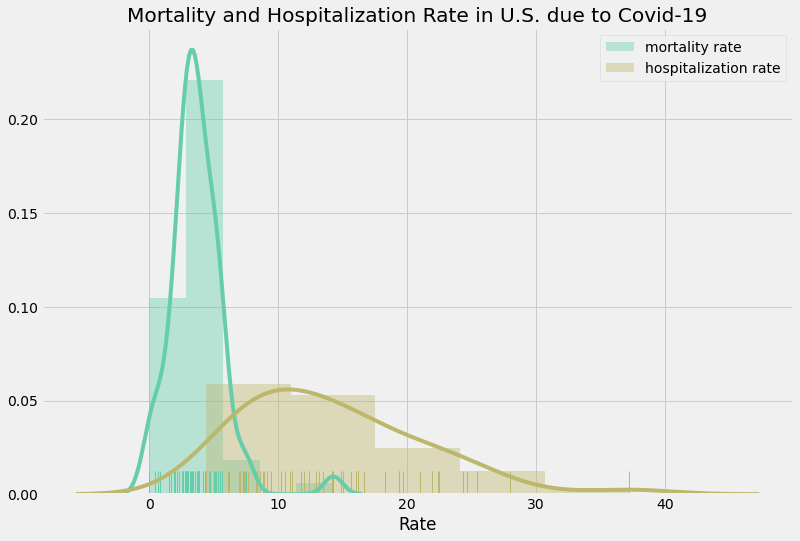

In [77]:
fig, axes= plt.subplots(1,1, figsize=(12,8))
sns.distplot(us_states['Mortality_Rate'], kde=True, bins=5, rug=True, color='mediumaquamarine', label='mortality rate')
sns.distplot(us_states['Hospitalization_Rate'], kde=True, bins=5, rug=True, color='darkkhaki', label='hospitalization rate')
axes.set(title = 'Mortality and Hospitalization Rate in U.S. due to Covid-19', xlabel = "Rate")
axes.legend();

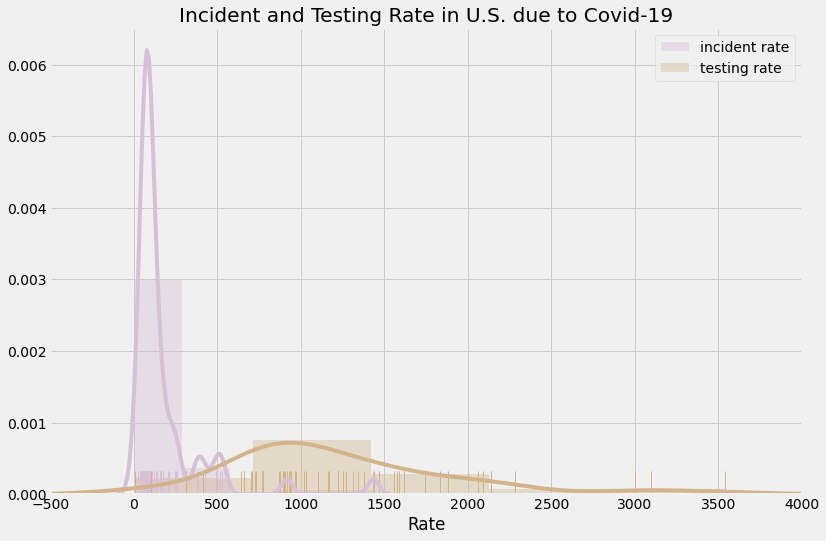

In [78]:
fig, axes= plt.subplots(1,1, figsize=(12,8))
sns.distplot(us_states['Incident_Rate'], kde=True, bins=5, rug=True, color='thistle', label='incident rate')
sns.distplot(us_states['Testing_Rate'], kde=True, bins=5, rug=True, color='tan', label='testing rate')
axes.set(title = 'Incident and Testing Rate in U.S. due to Covid-19', xlabel = "Rate")
axes.set(xlim=(-500, 4000))
axes.legend();

# **Data Cleaning and Standardization**

The goal of our analysis is to use the confirmed deaths and cases data for each county to predict future estimates over time. To promote fair comparisons, the following considerations were taken into account during standardization/cleaning of the data:
- **Only data from counties are used** (cruise ships, correctional facilities, unassigned values, etc are dropped) 
- **Adding Population** (simply using counts of cases is misleading since population totals change from county to county) 
- **Counties without any confirmed cases** (counties without any confirmed cases are dropped from the cases and deaths datasets to prevent imbalanced datasets. Note that there are counties with confirmed cases but no confirmed deaths) 
- **Erroneous populations** (Example: in one case, two counties (Dukes and Nantucket, Massachusetts) were lumped together in deaths and cases dataset, and population was erroneously given a 0 population count) 
- **Cases dataset given population totals** (the cases dataset was given a column for county populations as a modeling feature) 


The dataset of confirmed deaths has rows for each county in the United States. Taking a look at the null values for the **Admin2** column for county names, the null values are cruise ships (Grand Princess, Diamond Princess) and U.S. territories (Guam, Virgin Islands, etc). 

Given that different people regularly embark and disembark cruise ships, this data would not suit our regression models that aim to predict cumulative estimates of Covid-19 cases and deaths. Therefore, the analysis will be limited to only counties. While other counties provide death/case data that is cumulative over time, the Grand Princess cruise ship for example abruptly dropped their death count back to 0 on April 12, 2020 when their passengers disembarked. **Therefore, the cruise ships will be removed from our both the deaths and cases datasets.** 

In [79]:
#showing null values for county names in Admin2; similar results appear in cases dataset as well
deaths[deaths['Admin2'].isna()==True]

UID iso2 iso3  code3  ...  4/15/20 4/16/20 4/17/20 4/18/20
0           16   AS  ASM     16  ...        0       0       0       0
1          316   GU  GUM    316  ...        5       5       5       5
2          580   MP  MNP    580  ...        2       2       2       2
3          630   PR  PRI    630  ...       51      56      58      60
4          850   VI  VIR    850  ...        1       1       2       3
3200  84088888   US  USA    840  ...        0       0       0       0
3252  84099999   US  USA    840  ...        0       0       0       0

[7 rows x 100 columns]

In [0]:
deaths = deaths[(deaths['Province_State'] != 'Diamond Princess') & (deaths['Province_State'] != 'Grand Princess')]
cases = cases[(cases['Province_State'] != 'Diamond Princess') & (cases['Province_State'] != 'Grand Princess')]

To aid in future merging with other datasets, the null values in both deaths and cases datasets for the U.S. territories in **Admin2** will be replaced with their **Province_State** name. The province names for these locations will be effectively act as county names. Now, there are 0 null values for country names in **Admin2**.

In [0]:
filler_deaths = list(deaths[deaths['Admin2'].isna()==True]['Province_State'])
filler_cases = list(cases[cases['Admin2'].isna()==True]['Province_State'])
deaths.loc[deaths.Admin2.isnull(), 'Admin2'] = filler_deaths
cases.loc[cases.Admin2.isnull(), 'Admin2'] = filler_cases

In addition to null values representing county names, there are also 51 data entries that label the county to be "Unassigned". Taking a closer look at the death counts, the values are not all cumulative over time, which suggests that these values may be misreported or may represent non-cumulative information. **Since the goal of our analysis is to potentially predict death/cases rates for different counties, these unassigned rows will be dropped from our dataset.** 

In [82]:
#showing county names that are unassigned in Admin2; similar results appear in deaths dataset
cases[cases['Admin2'] == 'Unassigned']

UID iso2 iso3  code3  ...  4/15/20 4/16/20 4/17/20 4/18/20
3201  84090001   US  USA    840  ...        0       0       0       0
3202  84090002   US  USA    840  ...        0       0       0       0
3203  84090004   US  USA    840  ...        0       0       0       0
3204  84090005   US  USA    840  ...       48      44      43      42
3205  84090006   US  USA    840  ...        0       0       0       0
3206  84090008   US  USA    840  ...      119     111      96      67
3207  84090009   US  USA    840  ...      537     534     495     525
3208  84090010   US  USA    840  ...       17      17      22      30
3209  84090011   US  USA    840  ...        0       0       0       0
3210  84090012   US  USA    840  ...        5       6       4       3
3211  84090013   US  USA    840  ...      263     144     255     220
3212  84090015   US  USA    840  ...        1       1       5       0
3213  84090016   US  USA    840  ...        0       0       0       0
3214  84090017   US  USA    840  ...       45      55      74      84
3215  84090018   US  USA    840  ...        0       0       0       0
3216  84090019   US  USA    840  ...        0       0       1       1
3217  84090020   US  USA    840  ...        0       0       0       0
3218  84090021   US  USA    840  ...       78      77      87      73
3219  84090022   US  USA    840  ...       56      56      56      57
3220  84090023   US  USA    840  ...        2       2       1       1
3221  84090024   US  USA    840  ...        0       0       0       0
3222  84090025   US  USA    840  ...      572     638     760     733
3223  84090026   US  USA    840  ...       76      76      46      48
3224  84090027   US  USA    840  ...        2       2       0       0
3225  84090028   US  USA    840  ...        0       0       0       0
3226  84090029   US  USA    840  ...        0       0       0       0
3227  84090030   US  USA    840  ...        0       0       0       0
3228  84090031   US  USA    840  ...       19      23      92      60
3229  84090032   US  USA    840  ...        5       2      98      34
3230  84090033   US  USA    840  ...        0       0       2       0
3231  84090034   US  USA    840  ...     1189    1048     719     748
3232  84090035   US  USA    840  ...        0       0       0       0
3233  84090036   US  USA    840  ...        0       0       0       0
3234  84090037   US  USA    840  ...        0       0       0       0
3235  84090038   US  USA    840  ...        0       0       0       0
3236  84090039   US  USA    840  ...        0       0       0       0
3237  84090040   US  USA    840  ...        0       0     108     108
3238  84090041   US  USA    840  ...        0       0       0       0
3239  84090042   US  USA    840  ...        0       0       0       0
3240  84090044   US  USA    840  ...      756     902     790    1146
3241  84090045   US  USA    840  ...        0       0       0       0
3242  84090046   US  USA    840  ...        0       0       0       0
3243  84090047   US  USA    840  ...      136     197     209      37
3244  84090048   US  USA    840  ...        0       0       0       0
3245  84090049   US  USA    840  ...        0       0       0       0
3246  84090050   US  USA    840  ...       15      15      10      10
3247  84090051   US  USA    840  ...        0       0       0       0
3248  84090053   US  USA    840  ...      383     272     334     444
3249  84090054   US  USA    840  ...        0       0       0       0
3250  84090055   US  USA    840  ...        1       0       0       0
3251  84090056   US  USA    840  ...        0       0       0       0

[51 rows x 99 columns]

In [0]:
cases = cases[cases['Admin2'] != 'Unassigned']
deaths = deaths[deaths['Admin2'] != 'Unassigned']

A similar situation is seen in with **Admin2** names that label the counties as "Out of AL" or "Out of CA" for different states. **Since these data entries do not correspond to any particular county, these values will also be dropped from our datasets.**

In addition, it is found that two entries correspond to the Michigan Department of Corrections (MDOC)	facilities. **Since these locations are not counties as well, these two correctional facilities will also be dropped from the dataset.** 

In [84]:
#Unusual entries that do not correpond to any particular county, found while analyzing erroneous lat/long values 
#similar results appear in the deaths dataset
cases[cases['Lat'] == 0]

UID iso2 iso3  code3  ...  4/15/20 4/16/20 4/17/20 4/18/20
3149  84080001   US  USA    840  ...        0       0       0       0
3150  84080002   US  USA    840  ...        0       0       0       0
3151  84080004   US  USA    840  ...        0       0       0       0
3152  84080005   US  USA    840  ...        0       0       0       0
3153  84080006   US  USA    840  ...        0       0       0       0
3154  84080008   US  USA    840  ...        0       0       0       0
3155  84080009   US  USA    840  ...        0       0       0       0
3156  84080010   US  USA    840  ...        0       0       0       0
3157  84080011   US  USA    840  ...        0       0       0       0
3158  84080012   US  USA    840  ...        0       0       0       0
3159  84080013   US  USA    840  ...      683     707     780     815
3160  84080015   US  USA    840  ...        0       6       6       6
3161  84080016   US  USA    840  ...        0       0       0       0
3162  84080017   US  USA    840  ...        0       0       0       0
3163  84080018   US  USA    840  ...        0       0       0       0
3164  84080019   US  USA    840  ...        0       0       0       0
3165  84080020   US  USA    840  ...        0       0       0       0
3166  84080021   US  USA    840  ...        0       0       0       0
3167  84080022   US  USA    840  ...        0       0       0       0
3168  84080023   US  USA    840  ...        0       0       0       0
3169  84080024   US  USA    840  ...        0       0       0       0
3170  84080025   US  USA    840  ...        0       0       0       0
3171  84080026   US  USA    840  ...      166     166      71      74
3172  84080027   US  USA    840  ...        0       0       0       0
3173  84080028   US  USA    840  ...        0       0       0       0
3174  84080029   US  USA    840  ...        0       0       0       0
3175  84080030   US  USA    840  ...        0       0       0       0
3176  84080031   US  USA    840  ...        0       0       0       0
3177  84080032   US  USA    840  ...        0       0       0       0
3178  84080033   US  USA    840  ...        0       0       0       0
3179  84080034   US  USA    840  ...        0       0       0       0
3180  84080035   US  USA    840  ...        0       0       0       0
3181  84080036   US  USA    840  ...        0       0       0       0
3182  84080037   US  USA    840  ...        0       0       0       0
3183  84080038   US  USA    840  ...        0       0       0       0
3184  84080039   US  USA    840  ...        0       0       0       0
3185  84080040   US  USA    840  ...        0       0       0       0
3186  84080041   US  USA    840  ...        0       0       0       0
3187  84080042   US  USA    840  ...        0       0       0       0
3188  84080044   US  USA    840  ...        0       0       0       0
3189  84080045   US  USA    840  ...        0       0       0       0
3190  84080046   US  USA    840  ...        0       0       0       0
3191  84080047   US  USA    840  ...      260     243     250     259
3192  84080048   US  USA    840  ...        0       0       0       0
3193  84080049   US  USA    840  ...        0       0       0       0
3194  84080050   US  USA    840  ...        0       0       0       0
3195  84080051   US  USA    840  ...        0       0       0       0
3196  84080053   US  USA    840  ...        0       0       0       0
3197  84080054   US  USA    840  ...        0       0       0       0
3198  84080055   US  USA    840  ...        0       0       0       0
3199  84080056   US  USA    840  ...        0       0       0       0
3253  84070004   US  USA    840  ...      472     472     514     550
3254  84070005   US  USA    840  ...       36      36      44      45

[53 rows x 99 columns]

In [0]:
deaths = deaths[deaths['Lat'] != 0]
cases = cases[cases['Lat'] != 0]

As seen in the Exploratory Data Analysis section above, it can be seen that there are a substantial proportion (approximately 14% of the dataset) of counties without a single confirmed case of Covid-19 as of 4/18/20. Since the goal of our models is to predict future estimates of cases and deaths, it would be pointless to train on nonexistent data. This high prevalence of 0 values would also lead to an imbalanced dataset, where the model may overfit and tend to predict exclusively 0 values. 

**Therefore, the counties without a single confirmed case will be dropped from the dataset. These same counties will be dropped from the deaths dataset. Note that there are counties with confirmed cases, but no deaths as of 4/18/20.**

In [86]:
proportion_of_zeros = cases[cases['4/18/20'] ==0].shape[0]/cases.shape[0]
print(f'The proportion of counties with 0 confirmed cases as of 4/18/20: {proportion_of_zeros:.3f}')

The proportion of counties with 0 confirmed cases as of 4/18/20: 0.140


In [0]:
no_cases_id = cases[cases['4/18/20']==0]['UID']

cases = cases[cases['4/18/20'] !=0]
deaths = deaths[~deaths['UID'].isin(no_cases_id)]

Taking a look at the **Population** column provided in the deaths dataset, there is a single entry for the Dukes and Nantucket counties with a population of 0. It appears that these two counties were lumped together in this dataset, and a population count wasn't inputted properly. **Therefore, using the counties dataset, the 2018 population estimate for both counties were summed and imputed to replace the erroneous 0 value.**

In [88]:
counties[(counties['CountyName']=='Dukes') | (counties['CountyName']=='Nantucket')][['CountyName', 'PopulationEstimate2018']]

CountyName  PopulationEstimate2018
1216      Dukes                 17352.0
1222  Nantucket                 11327.0

In [89]:
deaths.at[3147, 'Population'] = 17352.0 + 11327.0
deaths[deaths['Admin2']=='Dukes and Nantucket']

UID iso2 iso3  code3  ...  4/15/20 4/16/20 4/17/20 4/18/20
3147  84070002   US  USA    840  ...        1       1       1       1

[1 rows x 100 columns]

Since the cases dataset doesn't have a column for population, the population column from the deaths dataset will be copied over. 

In [90]:
cases['Population'] = deaths['Population']
cases.head()

UID iso2 iso3  code3  ...  4/16/20 4/17/20 4/18/20 Population
1       316   GU  GUM    316  ...      135     136     136     164229
2       580   MP  MNP    580  ...       13      13      14      55144
3       630   PR  PRI    630  ...     1043    1068    1118    2933408
4       850   VI  VIR    850  ...       51      51      53     107268
5  84001001   US  USA    840  ...       26      26      25      55869

[5 rows x 100 columns]

# **Modeling and Experiments**
Due to the current nature of Covid-19, any type of regression modeling to predict future cases and deaths is considered unsupervised learning. However, in order to use metrics that test the accuracy of our models, we will use the available data from the dates 1/22/20 - 4/11/18 as features to predict death/cases counts for 4/18/20. Early predictions of Covid-19 in modeling would be more beneficial since this gives counties time to prepare. We do not include the week of 4/11/20 - 4/17/20 because want to do early predictions and not overtrain the model. In this way, the available data 4/18/20 will be used as true values that can be compared to the predicted values. 

Regression will be performed on the cases and deaths datasets separately.

### **Goals:**
- Use OLS, RIDGE, LASSO models to predict the spread of COVID in the next few months
- Determing which features are most important using cross validation
- Assess the accuracy of each model 



In [0]:
X_deaths = deaths.iloc[:, 11:].drop(columns=['4/11/20','4/12/20','4/13/20','4/14/20','4/15/20','4/16/20','4/17/20','4/18/20'])
y_deaths = deaths[['4/18/20']]

X_cases = cases.iloc[:, 11:].drop(columns=['4/11/20','4/12/20','4/13/20','4/14/20','4/15/20','4/16/20','4/17/20','4/18/20'])
y_cases = cases[['4/18/20']]

**To perform modeling and analysis on our dataset, the dataset will be split into training and validation sets:**
- Training set 70%
- Validation set 15%
- Testing set 15%

In [92]:
np.random.seed(30)

# Train/Test Split
Xtrain_deaths, Xtest_deaths, ytrain_deaths, ytest_deaths = train_test_split(X_deaths, y_deaths, train_size = .70, test_size = .30)
Xtrain_cases, Xtest_cases, ytrain_cases, ytest_cases = train_test_split(X_cases, y_cases, train_size = .70, test_size = .30)

# Test/Validation Split
Xtest_deaths, Xvalidate_deaths, ytest_deaths, yvalidate_deaths = train_test_split(Xtest_deaths, ytest_deaths, train_size = .50, test_size = .50)
Xtest_cases, Xvalidate_cases, ytest_cases, yvalidate_cases = train_test_split(Xtest_cases, ytest_cases, train_size = .50, test_size = .50)

# Verifying the shape of each split. 
print(Xtrain_deaths.shape, Xtest_deaths.shape, Xvalidate_deaths.shape, ytrain_deaths.shape, ytest_deaths.shape, yvalidate_deaths.shape)
print(Xtrain_cases.shape, Xtest_cases.shape, Xvalidate_cases.shape, ytrain_cases.shape, ytest_cases.shape, yvalidate_cases.shape)

(1896, 81) (406, 81) (407, 81) (1896, 1) (406, 1) (407, 1)
(1896, 81) (406, 81) (407, 81) (1896, 1) (406, 1) (407, 1)


## **Least Squares Regression Model**
As a baseline model, the analysis will start with the Least Squares Linear Regression model.
### **Why Least Squares?**
OLS is an optimization method that minimizes the sum of the squared residuals. $RSS = \sum_{i=1}^n (y_{i} - \hat{y_{i}})^2$. For example, this method will draw a linear line through data points that will minimize the distance between those points and the predicted values on that line. In this case, the function is parametric since there is a linear relationship, $y = \beta_{0} + \beta_{1}x$ in which the parameters $\beta_{0}, \beta_{1}$ are known. OLS is best used when the underlying data itself has a linear association, and a line of best fit can be drawn through the data. This makes it easy and efficient to implement either by hand or through computational linear algebra. OLS is easily interpretable and understandable, in which the best prediction for an underlying linear distribution should be the line of best fit. 

However, the least squares method is very susceptible to outliers because of the squaring effect of the calculation. In addition, OLS (not surprisingly) does poorly when used to model nonlinear distributions. For example, a sinusoidal or parabolic curve cannot be well modeled by a single straight line through the data. 


In [0]:
#Functions used in analyzing this model. 
def standard_units(x):
    return (x - x.mean()) / x.std() 

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def correlation(x, y):
    return np.sum(standard_units(x)*standard_units(y))/len(x)

### Deaths

In [0]:
lin_reg_deaths = LinearRegression(normalize=True)
lin_reg_deaths.fit(Xtrain_deaths, ytrain_deaths)

lin_reg_pred_deaths = lin_reg_deaths.predict(Xtrain_deaths)

In [95]:
print(f'The accuracy is: {lin_reg_deaths.score(Xtrain_deaths, ytrain_deaths)}')
print(f'The root mean squared error is: {rmse(lin_reg_pred_deaths, np.array(ytrain_deaths))}')
print(f'The correlation between actual and predicted values is: {correlation(lin_reg_pred_deaths, np.array(ytrain_deaths))}')

The accuracy is: 0.9899189800137906
The root mean squared error is: 5.6412767356529425
The correlation between actual and predicted values is: 0.9949467221986263


In the plots below, the actual and predicted death count values are plotted. The maximum value corresponding to predictions for New York are left out in the plot on the right to see the underlying distributions for the majority of the points. The differences in these two plots are more apparent when plotting the cases counts in the next parts. 

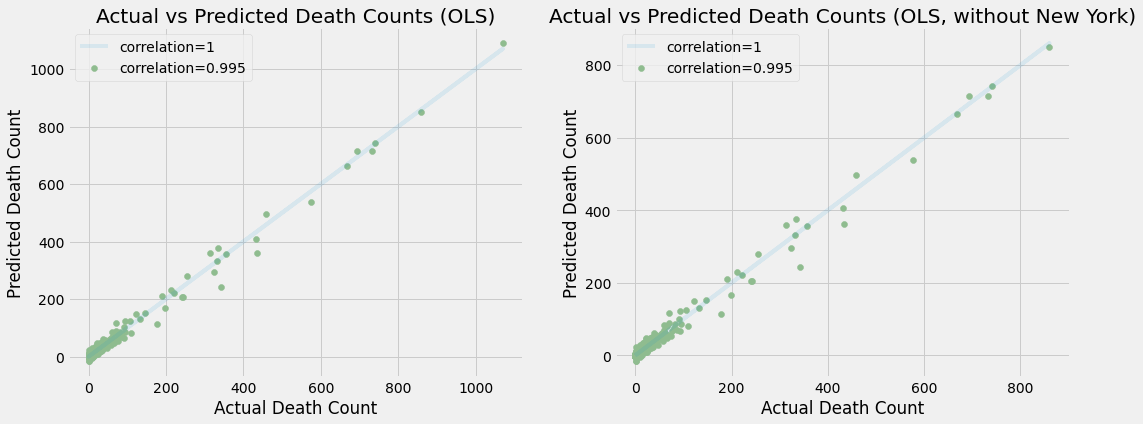

In [96]:
fig, axes= plt.subplots(1,2, figsize=(16,6))
axes = axes.flatten()
axes[0].scatter(ytrain_deaths, lin_reg_pred_deaths, color='darkseagreen', label='correlation=0.995')
axes[0].set(title='Actual vs Predicted Death Counts (OLS)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[0].plot(ytrain_deaths, ytrain_deaths, label= 'correlation=1', alpha=0.1)
axes[0].legend();

without_max = np.delete(lin_reg_pred_deaths, np.where(lin_reg_pred_deaths == lin_reg_pred_deaths.max()))
ytrain_deaths_array = np.array(ytrain_deaths)
without_max_ytrain = np.delete(ytrain_deaths_array,  np.where(lin_reg_pred_deaths == lin_reg_pred_deaths.max()))
axes[1].scatter(without_max_ytrain, without_max, color='darkseagreen', label='correlation=0.995')
axes[1].set(title='Actual vs Predicted Death Counts (OLS, without New York)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[1].plot(without_max_ytrain, without_max_ytrain, label= 'correlation=1', alpha=0.1)
axes[1].legend();

### Cases 

In [0]:
lin_reg_cases = LinearRegression(normalize=True)
lin_reg_cases.fit(Xtrain_cases, ytrain_cases)

lin_reg_pred_cases = lin_reg_cases.predict(Xtrain_cases)

In [98]:
print(f'The accuracy is: {lin_reg_cases.score(Xtrain_cases, ytrain_cases)}')
print(f'The root mean squared error is: {rmse(lin_reg_pred_cases, np.array(ytrain_cases))}')
print(f'The correlation between actual and predicted values is: {correlation(lin_reg_pred_cases, np.array(ytrain_cases))}')

The accuracy is: 0.9997677209700798
The root mean squared error is: 51.71940799568102
The correlation between actual and predicted values is: 0.9998838758179113


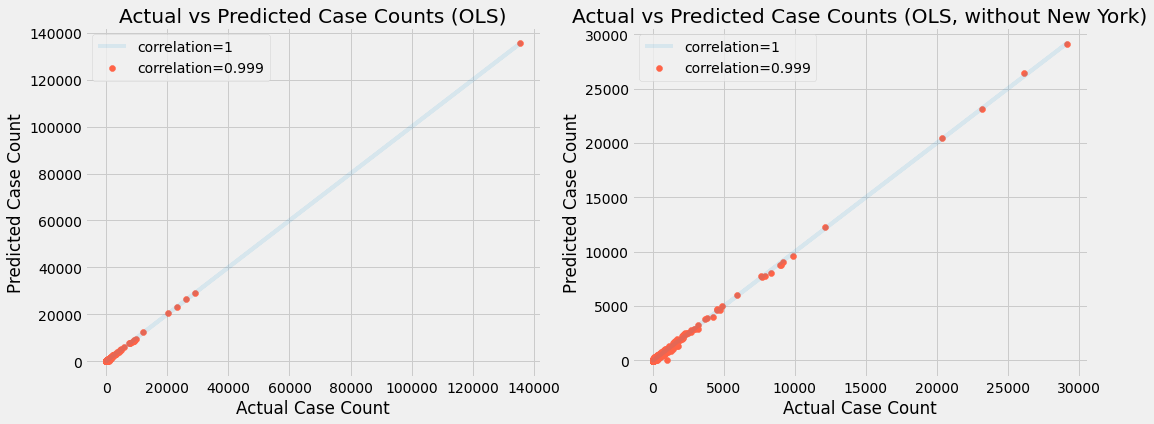

In [99]:
fig, axes= plt.subplots(1,2, figsize=(16,6));
axes = axes.flatten()

axes[0].scatter(ytrain_cases, lin_reg_pred_cases, color='tomato', label='correlation=0.999');
axes[0].set(title='Actual vs Predicted Case Counts (OLS)', xlabel='Actual Case Count', ylabel='Predicted Case Count');
axes[0].plot(ytrain_cases, ytrain_cases, label= 'correlation=1', alpha=0.1);
axes[0].legend();

without_max_c = np.delete(lin_reg_pred_cases, np.where(lin_reg_pred_cases == lin_reg_pred_cases.max()))
ytrain_cases_array_c = np.array(ytrain_cases)
without_max_ytrain_c = np.delete(ytrain_cases_array_c,  np.where(lin_reg_pred_cases == lin_reg_pred_cases.max()))
axes[1].scatter(without_max_ytrain_c, without_max_c, color='tomato', label='correlation=0.999')
axes[1].set(title='Actual vs Predicted Case Counts (OLS, without New York)', xlabel='Actual Case Count', ylabel='Predicted Case Count')
axes[1].plot(without_max_ytrain_c, without_max_ytrain_c, label= 'correlation=1', alpha=0.1)
axes[1].legend()

## **Ridge Regression Model**
### **Why Ridge Regression?**

Ridge regression is a type of squared loss regression used when the number of predictors exceeds the number of observations (eg. p>n) and when the model experiences multicollinearity. Since both p>n and multicollinearity are issues when using linear least squares regression, ridge regression would be used instead. Ridge regression works by using a shrinkage estimator that essentially would produce new estimates that are "shrunk" to the population's true parameters. It is a L2 "squared" regularization that adds a penalty equal to the squared magnitude of the coefficients. A tuning parameter  𝜆  would determine the strength of this penalty. 

However, a disadvantage to ridge regression is the tradeoff of bias for variance. Unlike least squares, the model is biased since the coefficients are given different weights, ie. biased estimators. The constraints put on each of the estimators helps to shrink extreme variance and fluctuations; this sacrifices training accuracy for a model that is likely to generalize better. In other words, ridge regression strives to introduce enough bias that shrinks variance to make estimates closer to the true population values.

### Deaths

In [0]:
ridge_reg_deaths = Ridge()
ridge_reg_deaths.fit(Xtrain_deaths, ytrain_deaths)
ridge_reg_pred_deaths = ridge_reg_deaths.predict(Xtrain_deaths)

In [101]:
print(f'The accuracy is: {ridge_reg_deaths.score(Xtrain_deaths, ytrain_deaths)}')
print(f'The root mean squared error is: {rmse(ridge_reg_pred_deaths, np.array(ytrain_deaths))}')
print(f'The correlation between actual and predicted values is: {correlation(ridge_reg_pred_deaths, np.array(ytrain_deaths))}')

The accuracy is: 0.9897601965203211
The root mean squared error is: 5.685530292752235
The correlation between actual and predicted values is: 0.9948669422511904


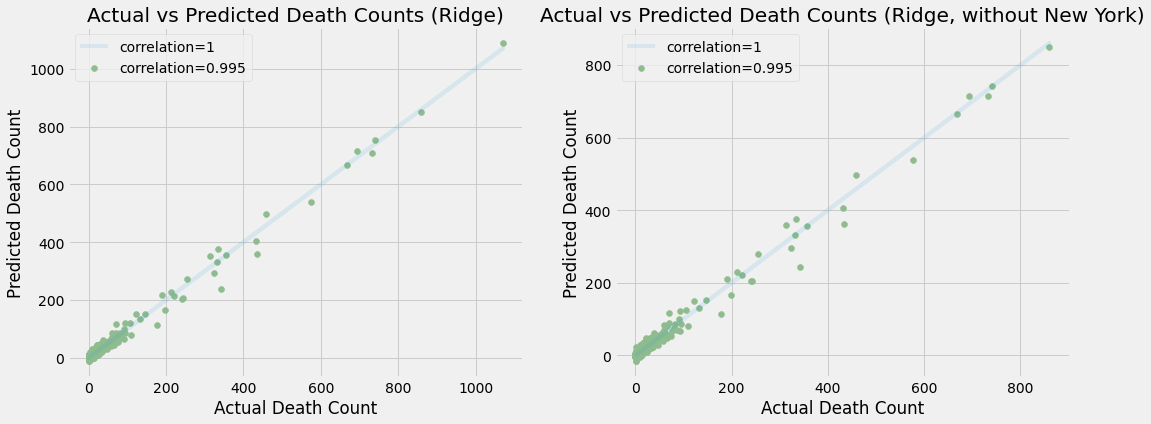

In [102]:
fig, axes= plt.subplots(1,2, figsize=(16,6))
axes = axes.flatten()

axes[0].scatter(ytrain_deaths, ridge_reg_pred_deaths, color='darkseagreen', label='correlation=0.995')
axes[0].set(title='Actual vs Predicted Death Counts (Ridge)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[0].plot(ytrain_deaths, ytrain_deaths, label= 'correlation=1', alpha=0.1)
axes[0].legend();

without_max_dr = np.delete(lin_reg_pred_deaths, np.where(lin_reg_pred_deaths == lin_reg_pred_deaths.max()))
ytrain_deaths_array_dr = np.array(ytrain_deaths)
without_max_ytrain_dr = np.delete(ytrain_deaths_array_dr,  np.where(lin_reg_pred_deaths == lin_reg_pred_deaths.max()))
axes[1].scatter(without_max_ytrain_dr, without_max_dr, color='darkseagreen', label='correlation=0.995')
axes[1].set(title='Actual vs Predicted Death Counts (Ridge, without New York)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[1].plot(without_max_ytrain_dr, without_max_ytrain_dr, label= 'correlation=1', alpha=0.1)
axes[1].legend();

The results from Ridge Regression remains very similar to the Linear Regression model. As part of
feature engineering, it would be beneficial to take a look at multicollinearity.


### Cases

In [0]:
ridge_reg_cases = Ridge()
ridge_reg_cases.fit(Xtrain_cases, ytrain_cases)
ridge_reg_pred_cases = ridge_reg_cases.predict(Xtrain_cases)

In [104]:
print(f'The accuracy is: {ridge_reg_cases.score(Xtrain_cases, ytrain_cases)}')
print(f'The root mean squared error is: {rmse(ridge_reg_pred_cases, np.array(ytrain_cases))}')
print(f'The correlation between actual and predicted values is: {correlation(ridge_reg_pred_cases, np.array(ytrain_cases))}')

The accuracy is: 0.9997650153455985
The root mean squared error is: 52.0197540085709
The correlation between actual and predicted values is: 0.9998825007725552


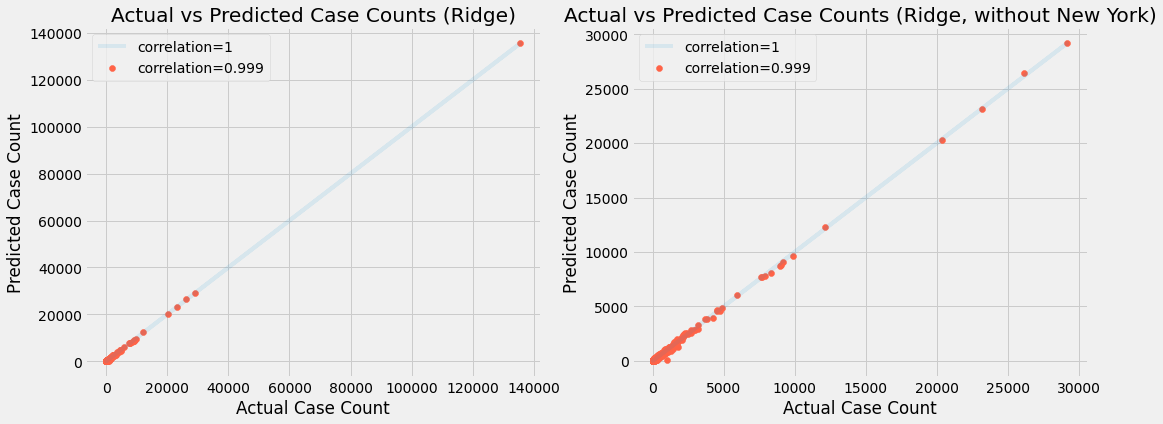

In [105]:
fig, axes= plt.subplots(1,2, figsize=(16,6));
axes = axes.flatten()

axes[0].scatter(ytrain_cases, ridge_reg_pred_cases, color='tomato', label='correlation=0.999');
axes[0].set(title='Actual vs Predicted Case Counts (Ridge)', xlabel='Actual Case Count', ylabel='Predicted Case Count');
axes[0].plot(ytrain_cases, ytrain_cases, label= 'correlation=1', alpha=0.1);
axes[0].legend();

without_max_cr = np.delete(ridge_reg_pred_cases, np.where(ridge_reg_pred_cases == ridge_reg_pred_cases.max()))
ytrain_cases_array_cr = np.array(ytrain_cases)
without_max_ytrain_cr = np.delete(ytrain_cases_array_cr,  np.where(ridge_reg_pred_cases == ridge_reg_pred_cases.max()))
axes[1].scatter(without_max_ytrain_cr, without_max_cr, color='tomato', label='correlation=0.999')
axes[1].set(title='Actual vs Predicted Case Counts (Ridge, without New York)', xlabel='Actual Case Count', ylabel='Predicted Case Count')
axes[1].plot(without_max_ytrain_cr, without_max_ytrain_cr, label= 'correlation=1', alpha=0.1)
axes[1].legend();

### **The Problem with Multicollinearity** 

There is a red line for y = -x because values should be correlated with themselves.  However, any red or blue columns show there’s a strong correlation/anticorrelation that requires more investigation. Since most of the values in the months of January and February show 0 confirmed deaths, the there is whitespace in the features correlation heatmap. 

**Regression assumes that the feature parameters used are independent from one another.**

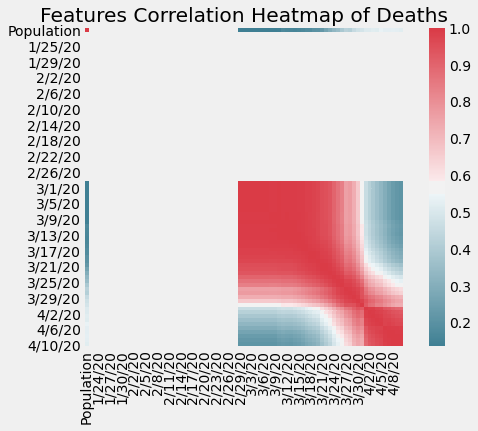

In [106]:
plt.subplots(1,1, figsize=(8,6))
corr = Xtrain_deaths.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.tight_layout()
plt.title('Features Correlation Heatmap of Deaths');

## **LASSO Regression Model**
### **Why LASSO?**
Lasso Regression (Least Absolute Shrinkage and Selection Operator) is similar to Ridge Regression in which it uses a shrinkage penalty as well. Instead of the L2 squared regularization, it uses the L1 regularization that takes the absolute value of the coefficient magnitudes. In this way, the model can be sparsed by giving some coefficients penalties of 0, effectively removing this estimator from the model. Lasso regression would potentially include fewer features while still solving the least squares issue of multicollinearity. Lasso regression is a parametric method. The same disadvantage of biasness mentioned above for Ridge regression also applies to the Lasso method as well.

In this iteration of linear regression using Lasso, a for loop has been set up to find the best alpha value:

In [0]:
alphas= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
CVPerformance = np.zeros((len(alphas), 2))

In [108]:
for i,a in enumerate(alphas):
  lasso = Lasso(alpha=a)
  scores = cross_val_score(lasso, Xtrain_deaths, ytrain_deaths, cv=5)
  CVPerformance[i][0] = a
  CVPerformance[i][1] = scores.mean()
CVPerformance

array([[1.00000000e-05, 9.26691962e-01],
       [1.00000000e-04, 9.27197575e-01],
       [1.00000000e-03, 9.31936502e-01],
       [1.00000000e-02, 9.47090035e-01],
       [1.00000000e-01, 9.40858438e-01],
       [1.00000000e+00, 9.47014293e-01]])

### Deaths 

In [0]:
lasso_reg_deaths = Lasso(alpha=1)
lasso_reg_deaths.fit(Xtrain_deaths, ytrain_deaths)
lasso_reg_pred_deaths = lasso_reg_deaths.predict(Xtrain_deaths)

In [110]:
print(f'The accuracy is: {lasso_reg_deaths.score(Xtrain_deaths, ytrain_deaths)}')
print(f'The root mean squared error is: {rmse(lasso_reg_pred_deaths, np.array(ytrain_deaths))}')
print(f'The correlation between actual and predicted values is:{correlation(lasso_reg_pred_deaths, np.array(ytrain_deaths))}')

The accuracy is: 0.9856726585766261
The root mean squared error is: 79.10518710431734
The correlation between actual and predicted values is:-1.097165021751137e-15


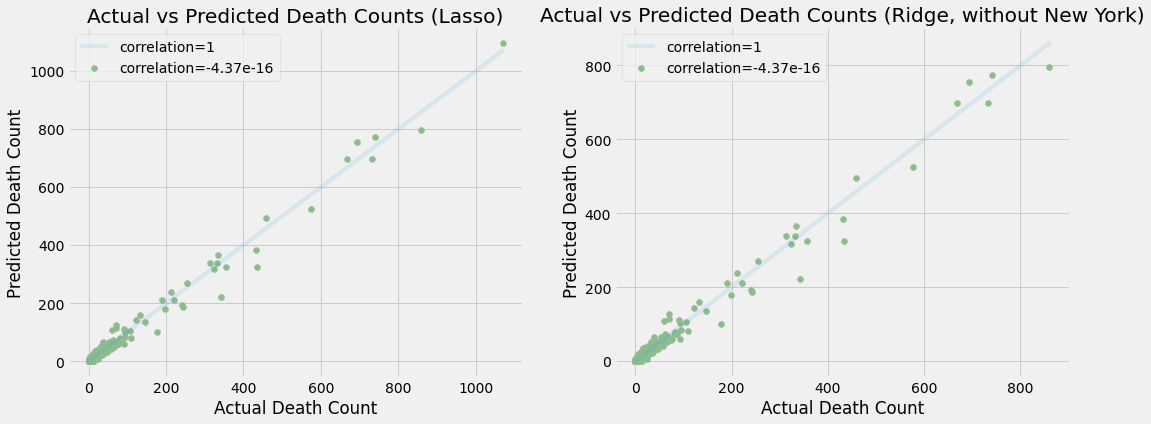

In [111]:
fig, axes= plt.subplots(1,2, figsize=(16,6))
axes = axes.flatten()

axes[0].scatter(ytrain_deaths, lasso_reg_pred_deaths, color='darkseagreen', label= 'correlation=-4.37e-16')
axes[0].set(title='Actual vs Predicted Death Counts (Lasso)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[0].plot(ytrain_deaths, ytrain_deaths, label= 'correlation=1', alpha=0.1)
axes[0].legend();

without_max_dl = np.delete(lasso_reg_pred_deaths, np.where(lasso_reg_pred_deaths == lasso_reg_pred_deaths.max()))
ytrain_deaths_array_dl = np.array(ytrain_deaths)
without_max_ytrain_dl = np.delete(ytrain_deaths_array_dl,  np.where(lasso_reg_pred_deaths == lasso_reg_pred_deaths.max()))
axes[1].scatter(without_max_ytrain_dl, without_max_dl, color='darkseagreen', label='correlation=-4.37e-16')
axes[1].set(title='Actual vs Predicted Death Counts (Ridge, without New York)', xlabel='Actual Death Count', ylabel='Predicted Death Count')
axes[1].plot(without_max_ytrain_dl, without_max_ytrain_dl, label= 'correlation=1', alpha=0.1)
axes[1].legend();

### Cases

In [0]:
lasso_reg_cases = Lasso(alpha=1)
lasso_reg_cases.fit(Xtrain_cases, ytrain_cases)
lasso_reg_pred_cases = lasso_reg_cases.predict(Xtrain_cases)

In [113]:
print(f'The accuracy is: {lasso_reg_cases.score(Xtrain_cases, ytrain_cases)}')
print(f'The root mean squared error is: {rmse(lasso_reg_pred_cases, np.array(ytrain_cases))}')
print(f'The correlation between actual and predicted values is:{correlation(lasso_reg_pred_cases, np.array(ytrain_cases))}')

The accuracy is: 0.9987522881922346
The root mean squared error is: 4798.780617376308
The correlation between actual and predicted values is:3.091760321740942e-17


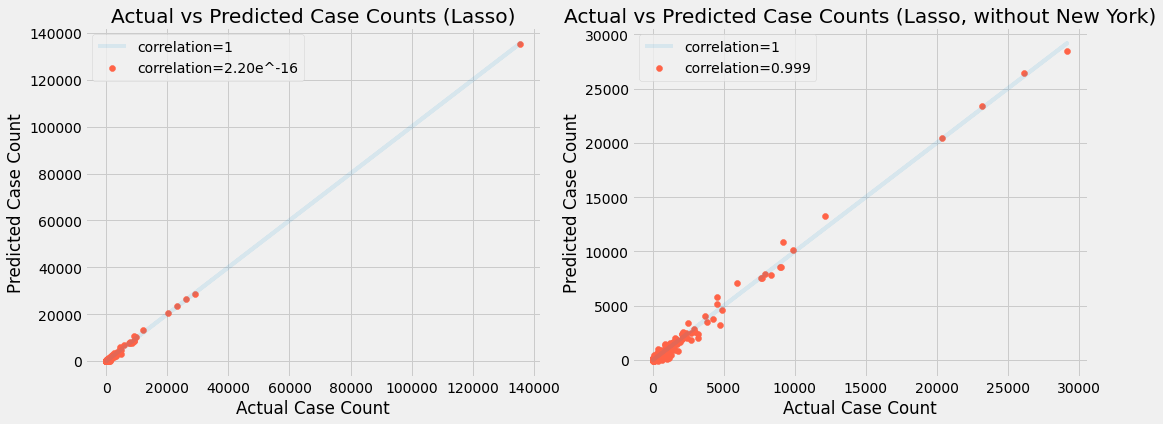

In [114]:
fig, axes= plt.subplots(1,2, figsize=(16,6));
axes = axes.flatten()

axes[0].scatter(ytrain_cases, lasso_reg_pred_cases, color='tomato', label='correlation=2.20e^-16');
axes[0].set(title='Actual vs Predicted Case Counts (Lasso)', xlabel='Actual Case Count', ylabel='Predicted Case Count');
axes[0].plot(ytrain_cases, ytrain_cases, label= 'correlation=1', alpha=0.1);
axes[0].legend();

without_max_cl = np.delete(lasso_reg_pred_cases, np.where(lasso_reg_pred_cases == lasso_reg_pred_cases.max()))
ytrain_cases_array_cl = np.array(ytrain_cases)
without_max_ytrain_cl = np.delete(ytrain_cases_array_cl,  np.where(lasso_reg_pred_cases == lasso_reg_pred_cases.max()))
axes[1].scatter(without_max_ytrain_cl, without_max_cl, color='tomato', label='correlation=0.999')
axes[1].set(title='Actual vs Predicted Case Counts (Lasso, without New York)', xlabel='Actual Case Count', ylabel='Predicted Case Count')
axes[1].plot(without_max_ytrain_cl, without_max_ytrain_cl, label= 'correlation=1', alpha=0.1)
axes[1].legend();

# **Modeling Conclusions**


### **Evaluation of Models Used and Numerical Results**
Overall, each model (Linear, Ridge, Lasso) produced relatively accurate 1-week predictions using only population totals and cumulative deaths and cases data for each county. In particular, the baseline Linear model showed an high accuracy scores of 98.9% for deaths predictions and 99.9% for cases predictions. The Ridge and Lasso models shows similar results. Even without training on the most immediate data (since we excluded data one week before 4/18/20), these predictions still scored high accuracy and correlation marks. The root mean squared error for the Linear model on deaths predictions is about 5.64, a relatively small distance between actual and predicted death vales. 

### **Challenges to the Data** 
As noted before in the section on Data Cleaning and Standardization of this notebook, there were significant data preparation involved to create training, validation, and testing sets that would fit our analysis. Since our goal is to get early predictions for the number of Covid-19 cases and deaths in each county, it was imperative to only select the rows corresponding to counties. The datasets were littered with extraneous data from unassigned counties, cruise ships, and even correctional facilities. In addition to this, some data entries were also misreported and did not follow the cumulative deaths and cases trends. In one case, two counties (Dukes and Nantucket, Massachusetts) were even lumped together in the datasets. This caused the corresponding population count to be erroneously given a 0 population value. These considerations were taken in the data cleaning process. 

### **Reflecting on Limitations**
There are a couple limitation to these models. First, we are limited by the the data we were given. Specifically, data collection plays a huge role in how our models will predict the spread of COVID. For example, testing in the United States is very limited. There are likely many more unconfirmed cases that. Also, some of the information provided such as number of hospital beds and ventilators are very dynamic and will change everyday based on the number of cases and deaths. Therefore, as the number of deaths and cases increase, the number of beds and equpiment do not remain constant. Some surprising discoveries we made were during data cleaning. There were some cruise ship  and correctional facilities listed in the data set while the majority were in the counties. From the news, we expected that men are more likely to die from COVID, however, from examining the data we were not able to draw those same conclusions. 

### **Potential Improvements to the Model**
The models can be improved if we had a larger data set to train with. The current model is trained on data up to 4/18. However, data 4/18 after would be important to determining the effectiveness of sheltering in place and the use of face masks. It is also likely that our model is overtrained, perhaps in the future we can cross validate on a greater fold. Additionally, if the data set were larger it would be computationally expensive to cross-validate on both L1 and L2 regularization penalties. The model could also be improved by eliminating outliars that might be disporpotionately skewing the data. Since we are limited by the amount of data we have, we could bootstrap the data to add more variation.

### **Ethical Concerns**
When using data-driven predictive models, researchers often look to increasing the amount of data to train their models on to increase accuracy of their models. Even in our analysis, it is obvious that there was an imbalanced dataset, where there were only a handful of counties with high (>1000) deaths and high (>10,000) confirmed cases. Imbalanced datasets potentially lead to overfitting of the model, in which the model trains more closely to high prevalence cases. However, it is unethical for researchers to push for more data on the spread of a potentially fatal disease. Solutions to overcome the limited data could be to oversample or bootstrap to create more variability. 

In addition, another ethical concern to these predictions arises from disproportionate funding of counties. If these predictive models are used to allocate resources for each county (eg. government aid, sending doctors, opening hospital space), this may create scenarios in which this model chooses which counties to save. For example, if the model predicts that the most cases will overwhelmingly be in New York, most of the government funding would be given to New York, effectively ignoring individuals in other counties. 
